In [60]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import r2_score, recall_score, make_scorer, f1_score, mean_squared_error

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression

from sklearn.preprocessing import StandardScaler, PolynomialFeatures #PowerTransformer

from sklearn.neighbors import KNeighborsRegressor


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('max_columns',300)

In [61]:
X = pd.read_csv('../datasets/data_clean.csv')

In [62]:
y = X['SalePrice']
z = X['Id']
X.drop('SalePrice', axis=1, inplace=True)
X.drop('Id', axis=1, inplace=True)
X.drop('Unnamed: 0', axis=1, inplace=True)
X.drop(['Roof Matl_CompShg','Roof Matl_Membran'],axis=1,inplace=True)

### Feature Engineering

In [63]:
X['Overall Qual Gr Liv Area'] = X['Overall Qual'] * X['Gr Liv Area']
X['Overall Qual^2'] = X['Overall Qual'] * X['Overall Qual']
X['Bathroom total'] = X['Full Bath'] + (0.5 * X['Half Bath'])

###

features_keep = list(abs(X.corrwith(y)).sort_values(ascending=False)[:-70].index)

In [64]:
X = X[features_keep]

### KNearestNeighbors Regressor Tuning

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

parameters = [{'weights': ['uniform', 'distance'],'n_neighbors': range(2,50,5),'p':range(1,3)}]

knnreg = GridSearchCV(KNeighborsRegressor(), parameters, cv=5, scoring='r2',n_jobs=3, verbose=2)


In [66]:
knnreg.fit(X_train_sc, y_train_log) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   26.9s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': range(2, 50, 5), 'p': range(1, 3)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [67]:
knnreg.best_score_

0.8093887062556794

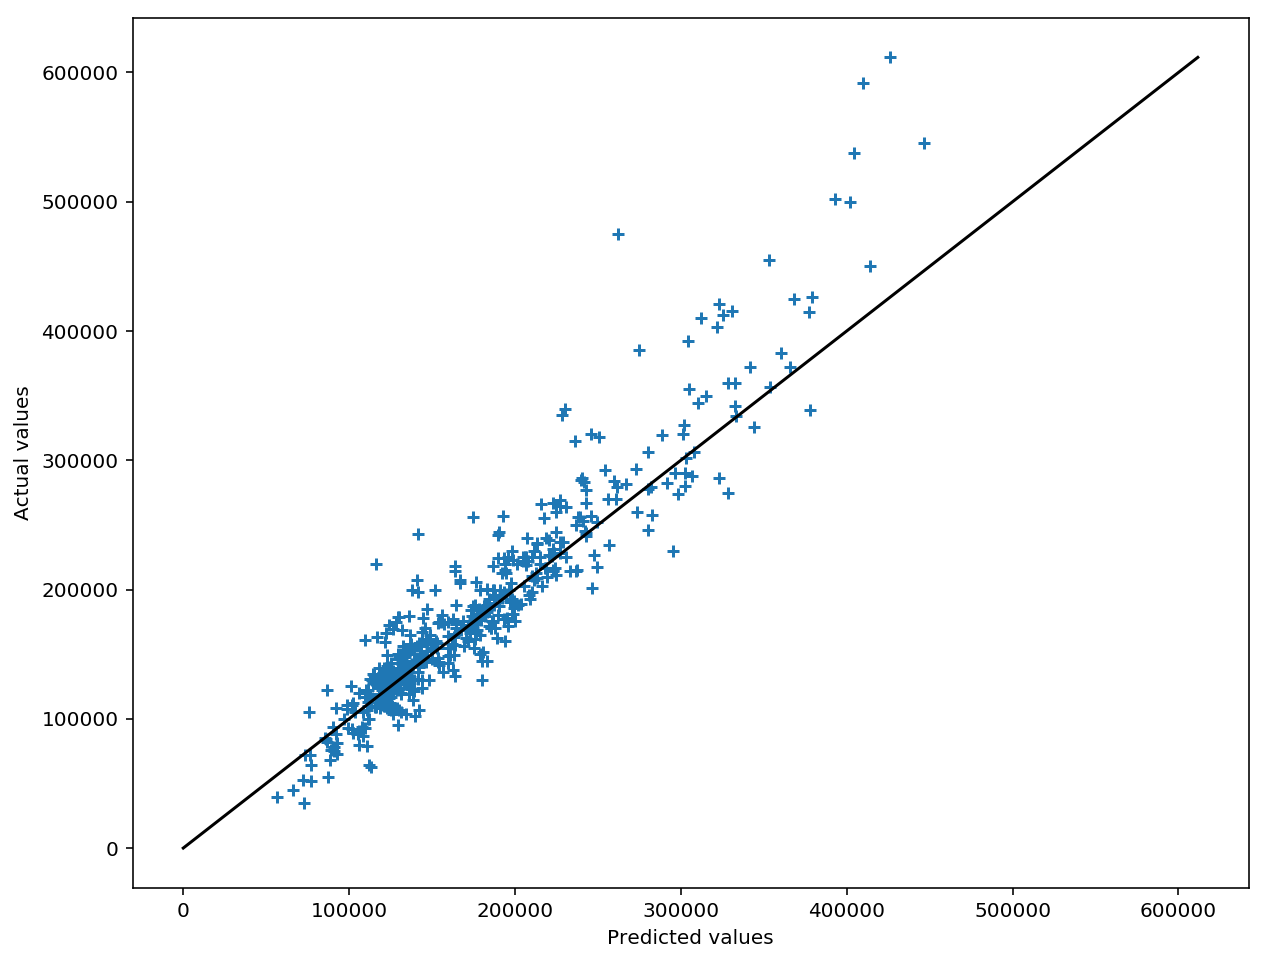

In [68]:
preds = knnreg.predict(X_test_sc)
plt.figure(figsize=(10,8))
plt.scatter(np.exp(preds),y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

### Fit to full 2000 set of houses and see how it trains

In [21]:
model = knnreg.best_estimator_

X_sc = ss.fit_transform(X)
y_log = np.log(y)

model.fit(X_sc,y_log)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=1,
          weights='distance')

### Apply to Testset for Kaggle Submission

In [22]:
testset = pd.read_csv('../datasets/test_clean.csv')

In [23]:
testset.drop('Unnamed: 0',axis=1,inplace=True)
testset.drop('Id',axis=1,inplace=True)

In [24]:
testset.drop(['Roof Matl_Metal','Roof Matl_Roll'],axis=1,inplace=True)

In [25]:
###Changes to testset go here:

def changes_to_testset(X):
    X['Overall Qual Gr Liv Area'] = X['Overall Qual'] * X['Gr Liv Area']
    X['Overall Qual^2'] = X['Overall Qual'] * X['Overall Qual']
    X['Bathroom total'] = X['Full Bath'] + (0.5 * X['Half Bath'])
    
changes_to_testset(testset)

testset = testset[features_keep]

In [26]:
testset_sc = ss.transform(testset)

predictions = model.predict(testset_sc)

In [ ]:
predictions

In [27]:
predictions = np.exp(predictions)
predictions

array([119843.12199606, 144819.69271392, 181207.826633  ,  88666.49313916,
       168449.23010211,  87355.90145457, 105238.47158049, 138262.14300207,
       159351.07489696, 161810.9597058 , 166389.68559198, 116074.78640725,
       135961.48863732, 269355.05668195, 162846.20831781, 122490.21343118,
       128252.50066245, 126609.03981863, 180333.15713494, 165208.08064196,
       130439.53065607, 135199.77434456, 178498.59439048, 236081.86181693,
       178655.83666484, 126598.62520839, 133697.09629153, 115499.15235171,
       139235.97441932,  86604.04086727, 112245.90653623, 102501.87068328,
       133796.0191686 , 158106.55955851, 205554.70746187, 170599.69018448,
       101207.54821088, 102144.0290721 , 141530.74907076, 207480.79564519,
       160129.35033404, 190530.64647337, 134554.26331487, 142423.18228738,
       222893.14406111,  85711.89223927, 213499.90395646, 118858.69564142,
       127483.92324841, 128461.72927591, 104342.33249582, 158493.91823597,
       246892.99717023, 1

In [28]:
testset['SalePrice'] = predictions

testfile = pd.read_csv('../datasets/test_clean.csv') 
testset['Id'] = testfile['Id']

In [29]:
submission = testset[['Id','SalePrice']]

In [30]:
submission.to_csv('../datasets/ef_ames_12_6_KNN.csv',index=False)

In [31]:
submission

,Id,SalePrice
0,2658,119843.121996
1,2718,144819.692714
2,2414,181207.826633
3,1989,88666.493139
4,625,168449.230102
5,333,87355.901455
6,1327,105238.471580
7,858,138262.143002
8,95,159351.074897
9,1568,161810.959706


In [40]:
X['SalePrice'] = y

In [41]:
X.head()

,Overall Qual Gr Liv Area,Overall Qual^2,Overall Qual,Exter Qual 2,Exter Qual,Gr Liv Area,Kitchen Qual,Kitchen Qual 2,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Bsmt Qual,Bathroom total,Year Built,Garage Finish,Garage Yr Blt,Year Remod/Add,Full Bath,Foundation_PConc,Fireplace Qu,Mas Vnr Area,TotRms AbvGrd,Fireplaces,Neighborhood_dummies_NridgHt,Heating QC,BsmtFin SF 1,Bsmt Exposure,Garage Type_Detchd,Sale Type_New,BsmtFin Type 1,Garage Type_Attchd,Foundation_CBlock,MS SubClass_60,Exterior 1st_VinylSd,Exterior 2nd_VinylSd,Lot Frontage,Open Porch SF,Wood Deck SF,Mas Vnr Type_Stone,Lot Area,Lot Shape,Paved Drive,Bsmt Full Bath,Half Bath,MS Zoning_RM,Central Air_Y,Garage Qual,Roof Style_Hip,Neighborhood_dummies_NoRidge,Mas Vnr Type_BrkFace,Neighborhood_dummies_StoneBr,PID,Garage Cond,Roof Style_Gable,2nd Flr SF,MS SubClass_30,Electrical,Garage Type_None,MS Zoning_RL,Garage Type_BuiltIn,Sale Type_WD,Land Contour_HLS,Bsmt Cond,Neighborhood_dummies_OldTown,House Style_2Story,Exterior 1st_Wd Sdng,Bsmt Unf SF,Neighborhood_dummies_IDOTRR,Neighborhood_dummies_NAmes,MS SubClass_50,Neighborhood_dummies_Edwards,Exterior 2nd_Wd Sdng,Exterior 1st_CemntBd,Lot Config_CulDSac,Alley Grvl,Exterior 2nd_CmentBd,Neighborhood_dummies_Somerst,Exterior 1st_MetalSd,Exterior 2nd_MetalSd,Enclosed Porch,Alley,Bedroom AbvGr,Screen Porch,Neighborhood_dummies_Sawyer,Neighborhood_dummies_BrkSide,Fence,Foundation_Slab,Functional,Kitchen AbvGr,Neighborhood_dummies_Timber,MS SubClass_160,Exterior 1st_HdBoard,Bldg Type_Twnhs,Condition 1_Feedr,Neighborhood_dummies_MeadowV,Bldg Type_2fmCon,Condition 1_Norm,MS SubClass_190,Condition 1_PosN,MS Zoning_FV,MS SubClass_90,Bldg Type_Duplex,Condition 2_PosN,Exterior 2nd_HdBoard,Condition 2_PosA,MS SubClass_120,Roof Matl_WdShngl,Overall Cond,Neighborhood_dummies_BrDale,Land Contour_Lvl,Lot Config_Inside,Neighborhood_dummies_Veenker,Neighborhood_dummies_CollgCr,MS SubClass_70,Neighborhood_dummies_SWISU,Mo Sold_4,Heating_Grav,Garage Type_CarPort,Condition 1_PosA,Street_Pave,House Style_1.5Unf,MS SubClass_180,Season_Spring,House Style_SFoyer,Bldg Type_TwnhsE,Exterior 2nd_Plywood,Exterior 2nd_Wd Shng,Exterior 1st_Stucco,MS SubClass_45,BsmtFin Type 2,Neighborhood_dummies_Crawfor,Land Slope,Garage Type_Basment,Sale Type_ConLD,Condition 1_RRAe,Neighborhood_dummies_ClearCr,Exterior 2nd_Stucco,Exter Cond,Exterior 1st_WdShing,3Ssn Porch,Exterior 2nd_Brk Cmn,Misc Feature_Shed,Neighborhood_dummies_NPkVill,SalePrice
0,8874,36,6,1,1,1479,1,1,475.0,2.0,725.0,725,2.5,2.5,1976,2,1976.0,2005,2,0,0.0,289.0,6,0,0,2,533.0,0,0,0,4.0,1,1,1,0,0,72.774648,44,0,0,13517,1,2,0.0,1,0,1,2.5,0,0,1,0,533352170,2.5,1,754,0,0.0,0,1,0,1,0,2.5,0,1,0,192.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1.5,0,0,0,0,1,0,0,0,0,0,0,0,0,130500
1,14854,49,7,1,1,2122,1,1,559.0,2.0,913.0,913,3.0,2.5,1996,2,1997.0,1997,2,1,2.5,132.0,8,1,0,2,637.0,0,0,0,4.0,1,0,1,1,1,43.000000,74,0,0,11492,1,2,1.0,1,0,1,2.5,0,0,1,0,531379050,2.5,1,1209,0,0.0,0,1,0,1,0,2.5,0,1,0,276.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1.5,0,0,0,0,0,0,0,0,0,0,0,0,0,220000
2,5285,25,5,0,0,1057,1,1,246.0,1.0,1057.0,1057,2.5,1.0,1953,1,1953.0,2007,1,0,0.0,0.0,5,0,0,0,731.0,0,1,0,4.0,0,1,0,1,1,68.000000,52,0,0,7922,0,2,1.0,0,0,1,2.5,0,0,0,0,535304180,2.5,1,0,0,0.0,0,1,0,1,0,2.5,0,0,0,326.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.5,0,0,0,0,0,0,0,1,0,0,0,0,0,109000
3,7220,25,5,0,0,1444,0,0,400.0,2.0,384.0,744,3.0,2.5,2006,3,2007.0,2007,2,1,0.0,0.0,7,0,0,1,0.0,0,0,0,1.5,0,0,1,1,1,73.000000,0,100,0,9802,0,2,0.0,1,0,1,2.5,0,0,0,0,916386060,2.5,1,700,0,0.0,0,1,1,1,0,2.5,0,1,0,384.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1.5,0,0,0,0,0,0,0,0,0,0,0,0,0,174000
4,8670,36,6,0,0,1445,0,

In [45]:
X.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).index[0:20]

Index(['SalePrice', 'Overall Qual Gr Liv Area', 'Overall Qual^2',
       'Overall Qual', 'Exter Qual 2', 'Exter Qual', 'Gr Liv Area',
       'Kitchen Qual', 'Kitchen Qual 2', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Bsmt Qual', 'Bathroom total',
       'Year Built', 'Garage Finish', 'Garage Yr Blt', 'Year Remod/Add',
       'Full Bath'],
      dtype='object')

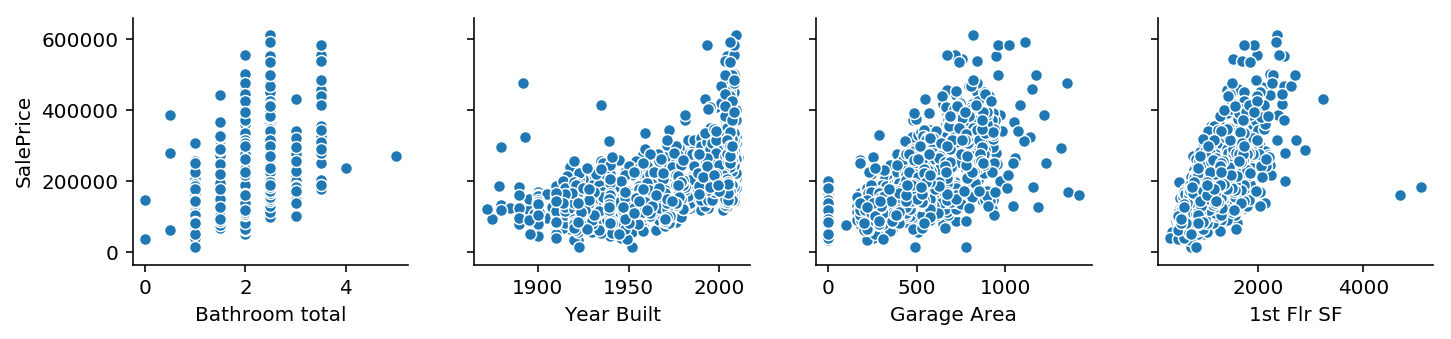

In [53]:

sns.pairplot(X,y_vars = ['SalePrice'], x_vars = ['Bathroom total','Year Built','Garage Area','1st Flr SF']);